In [8]:
import re
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


positions = ["qb", "rb", "wr", "te"]
# positions = ["qb"]

for pos in positions:
    print("Position: " + pos)
    # Load your dataset
    data = pd.read_csv("datasets/weekly_scoring.csv")

    # Preprocessing
    data = data[data['POS'] == pos]

    # Drop Zero values (bye weeks, injuries)
    data = data[data['MISC FPTS'] != 0]
    weights = data['WEIGHT']  

    
    # Instead of dropping zero values, substitute them with the mean (including zeroes) for everyone
    # column_to_replace = 'MISC FPTS'
    # mean_value = data[column_to_replace].mean()
    # data[column_to_replace] = data[column_to_replace].replace(0, mean_value)
    
    # Replace zero values with the mean specific to each player
    # player_means = data.groupby('PLAYER', group_keys=True)[column_to_replace].max()
    # data[column_to_replace] = data.groupby('PLAYER')[column_to_replace].apply(lambda x: x.replace(0, x.mean()))

    if(pos == 'qb'):
        # Define the list of variables to predict
        # columns_to_predict = ['PASSING CMP', 'PASSING ATT', 'PASSING PCT', 'PASSING YDS', 'PASSING Y/A', 'PASSING TD', 'PASSING INT',
        # 'PASSING SACKS', 'RUSHING ATT', 'RUSHING YDS', 'RUSHING TD', 'MISC FL', 'WEEK', 'AVG_FPTS', 'MAX_FPTS', 'MIN_FPTS', 'VAR_FPTS']
        columns_to_predict = ['MISC FPTS']
        # # Drop Zero values (bye weeks, injuries)
        # data = data[data['MISC FPTS'] != 0]
        look_back = 15
    if(pos == 'rb'):
        # columns_to_predict = ['RECEIVING REC', 'RECEIVING TGT', 'RECEIVING YDS', 'RECEIVING Y/R',
        # 'RECEIVING TD', 'RUSHING Y/A', 'RUSHING LG',
        # 'RUSHING 20+', 'RUSHING ATT', 'RUSHING YDS', 'RUSHING TD', 'MISC FL', 'AVG_FPTS', 'MAX_FPTS', 'VAR_FPTS']
        columns_to_predict = ['MISC FPTS']
        # # Replace zero values with the mean specific to each player
        # player_means = data.groupby('PLAYER', group_keys=True)[column_to_replace].max()
        # data[column_to_replace] = data.groupby('PLAYER')[column_to_replace].apply(lambda x: x.replace(0, x.mean()))
        look_back = 16
    if(pos == 'wr'):
        # columns_to_predict = ['RECEIVING REC', 'RECEIVING TGT', 'RECEIVING YDS', 'RECEIVING Y/R',
        # 'RECEIVING TD', 'RECEIVING LG', 'RECEIVING 20+',
        # 'RUSHING ATT', 'RUSHING YDS', 'RUSHING TD', 'MISC FL', 'MISC FPTS', 'WEEK', 'AVG_FPTS', 'MAX_FPTS', 'MIN_FPTS', 'VAR_FPTS']
        columns_to_predict = ['MISC FPTS']
        # # Replace zero values with the mean specific to each player
        # player_means = data.groupby('PLAYER', group_keys=True)[column_to_replace].max()
        # data[column_to_replace] = data.groupby('PLAYER')[column_to_replace].apply(lambda x: x.replace(0, x.mean()))
        look_back = 14
    if(pos == 'te'):
        # columns_to_predict = ['RECEIVING REC', 'RECEIVING TGT', 'RECEIVING YDS', 'RECEIVING Y/R',
        # 'RECEIVING TD', 'RECEIVING LG', 'RECEIVING 20+',
        # 'RUSHING ATT', 'RUSHING YDS', 'RUSHING TD', 'MISC FL', 'MISC FPTS', 'WEEK', 'AVG_FPTS', 'MAX_FPTS', 'MIN_FPTS', 'VAR_FPTS']
        columns_to_predict = ['MISC FPTS']
        # # Replace zero values with the mean specific to each player
        # player_means = data.groupby('PLAYER', group_keys=True)[column_to_replace].max()
        # data[column_to_replace] = data.groupby('PLAYER')[column_to_replace].apply(lambda x: x.replace(0, x.mean()))
        look_back = 20


    # Sort the data by the date column
    date_column = "CONTINUOUS_DATE"
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.sort_values(by=date_column)

    # Extract the relevant columns for training
    training_data = data[columns_to_predict].values

    # Impute missing values for training_data
    imputer = SimpleImputer(strategy='mean')  # You can change the strategy as needed
    training_data = imputer.fit_transform(training_data)
    # training_data[np.isnan(training_data)] = 0

    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    training_data_scaled = scaler.fit_transform(training_data)

    # Define a function to create LSTM datasets
    def create_lstm_dataset(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back)])
            Y.append(dataset[i + look_back])
        return np.array(X), np.array(Y)

    # Create the LSTM dataset
    X, Y = create_lstm_dataset(training_data_scaled, look_back)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]    
    # Reshape the input data for LSTM (samples, time steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=len(columns_to_predict)))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=0)

    # print("LSTM Model Summary:")
    # model.summary()

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Rescale the predictions to the original scale
    predictions_rescaled = scaler.inverse_transform(predictions)
    Y_test_rescaled = scaler.inverse_transform(Y_test)

    # Evaluate the model
    mse = mean_squared_error(Y_test_rescaled, predictions_rescaled)
    print(f'Mean Squared Error {pos}: {mse}')

    # Root Mean Squared Error (RMSE)
    # rmse = np.sqrt(mean_squared_error(Y_test_rescaled, predictions_rescaled))
    # print(f"RMSE {pos}: {rmse}")

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(Y_test_rescaled, predictions_rescaled)
    print(f"MAE {pos}: {mae}")

    # R-squared
    r_squared = r2_score(Y_test_rescaled, predictions_rescaled)
    print(f"R-squared {pos}: {r_squared}")

    # Top K Accuracy

    def top_k_accuracy_metric(y_true, y_pred, k=5):
        # Get the indices of the top-k predicted values
        top_k_pred = np.argsort(y_pred)[-k:]
        top_k_true = np.argsort(y_true)[-k:]
        # print(y_true.shape[2])
        # print(y_pred.shape[2])
        i = 0
        for j in top_k_pred:
            if j in top_k_true:
                i=i+1
        
        # Calculate the top-k accuracy
        top_k_acc = i/k
        return top_k_acc

    
    k = 5  # Choose the value of k for top-k accuracy
    top_k_acc = top_k_accuracy_metric(Y_test_rescaled, predictions_rescaled, 5)
    print(f"Top-{k} Accuracy: {top_k_acc}")

   
    ############ feature importance ######################

    # Create a copy of the original X_test
    X_test_permuted = X_test.copy()

    # Get the number of features
    num_features = X_test.shape[2]

    # Initialize an array to store permutation importances
    importances = np.zeros(num_features)

    # Loop over each feature
    for feature_idx in range(num_features):
        # Permute the values of the current feature
        X_test_permuted[:, :, feature_idx] = np.random.permutation(X_test[:, :, feature_idx])

        # Make predictions on the permuted data
        predictions_permuted = model.predict(X_test_permuted)

        # Rescale the predictions to the original scale
        predictions_permuted_rescaled = scaler.inverse_transform(predictions_permuted)

        # Calculate the metric of interest (MAE in this case) on the permuted predictions
        mae_permuted = mean_absolute_error(Y_test_rescaled, predictions_permuted_rescaled)

        # Calculate the change in metric and store the importance
        importances[feature_idx] = mae - mae_permuted

        # Reset the permuted feature to its original values
        X_test_permuted[:, :, feature_idx] = X_test[:, :, feature_idx]

    # Print or store the feature importances
    feature_indices = np.argsort(importances)[::-1]
    print("Permutation Importances:")
    for idx in feature_indices:
        print(f"{columns_to_predict[idx]}: {importances[idx]}")

    # Create a DataFrame to store the results
    results_list = []

    # Create a DataFrame with 'PLAYER' and predicted values
    result_df = pd.DataFrame({'PLAYER': data['PLAYER'].iloc[train_size + look_back:], 'Predicted_FPTS': predictions_rescaled[:, 0]})

    # Group by 'PLAYER' and calculate the average predicted FPTS
    result_df = result_df.groupby('PLAYER').mean().reset_index()
    result_df = result_df.sort_values(by='Predicted_FPTS', ascending=False)

    # Add the 'TEAM' column if needed (replace with your own logic)
    pattern = r'\((.*?)\)'
    result_df['TEAM'] = result_df['PLAYER'].apply(lambda x: re.search(pattern, x).group(1) if re.search(pattern, x) else pd.NA)

    # # Keep only the first unique occurrence of any value in the 'TEAM' column
    # result_df = result_df.drop_duplicates(subset='TEAM')

    # Append the results to the list
    results_list.append(result_df)

    # Combine the results from all folds
    final_results_df = pd.concat(results_list, ignore_index=True)

    # Remove any player with the team equal to 'FA'
    final_results_df = final_results_df.query("TEAM != 'FA'")

    # Save the results to a CSV file
    file_name = f"predictions/LSTM_predictions_{pos}.csv"
    final_results_df.to_csv(file_name, index=False)

    print("")

Position: qb
11/11 [==============================] - 0s 918us/step
Mean Squared Error qb: 24.138194655250146
MAE qb: 3.293417533073652
R-squared qb: 0.703398440297131
Top-5 Accuracy: 1.0
11/11 [==============================] - 0s 825us/step
Permutation Importances:
MISC FPTS: -6.708821446110303

Position: rb
24/24 [==============================] - 0s 874us/step
Mean Squared Error rb: 10.356508719686124
MAE rb: 1.7587124058885244
R-squared rb: 0.7731407150529799
Top-5 Accuracy: 1.0
24/24 [==============================] - 0s 833us/step
Permutation Importances:
MISC FPTS: -5.03226998672384

Position: wr
33/33 [==============================] - 0s 754us/step
Mean Squared Error wr: 6.448234692617513
MAE wr: 1.1966259167677629
R-squared wr: 0.802579609842816
Top-5 Accuracy: 1.0
33/33 [==============================] - 0s 708us/step
Permutation Importances:
MISC FPTS: -4.412799992293942

Position: te
16/16 [==============================] - 0s 1ms/step
Mean Squared Error te: 5.96371990606

# Visualization of Results

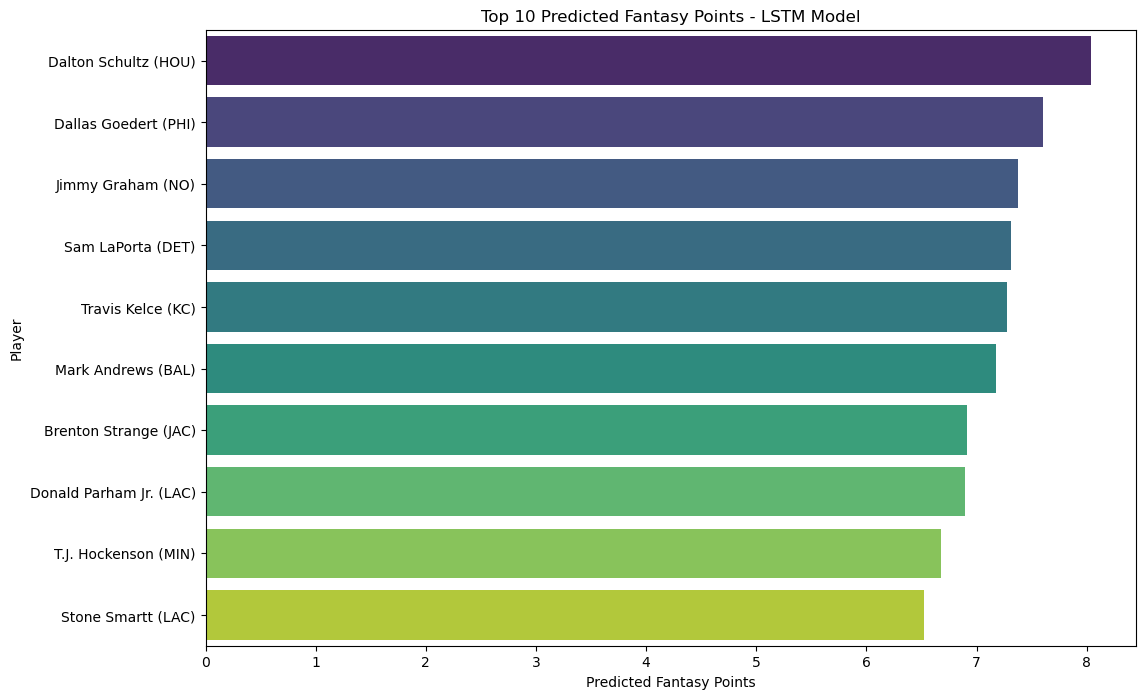

In [9]:
import seaborn as sns

# Bar Plot for Top Predicted Fantasy Points
plt.figure(figsize=(12, 8))
sns.barplot(x='Predicted_FPTS', y='PLAYER', data=final_results_df.head(10), palette='viridis')
plt.title('Top 10 Predicted Fantasy Points - LSTM Model')
plt.xlabel('Predicted Fantasy Points')
plt.ylabel('Player')
plt.show()

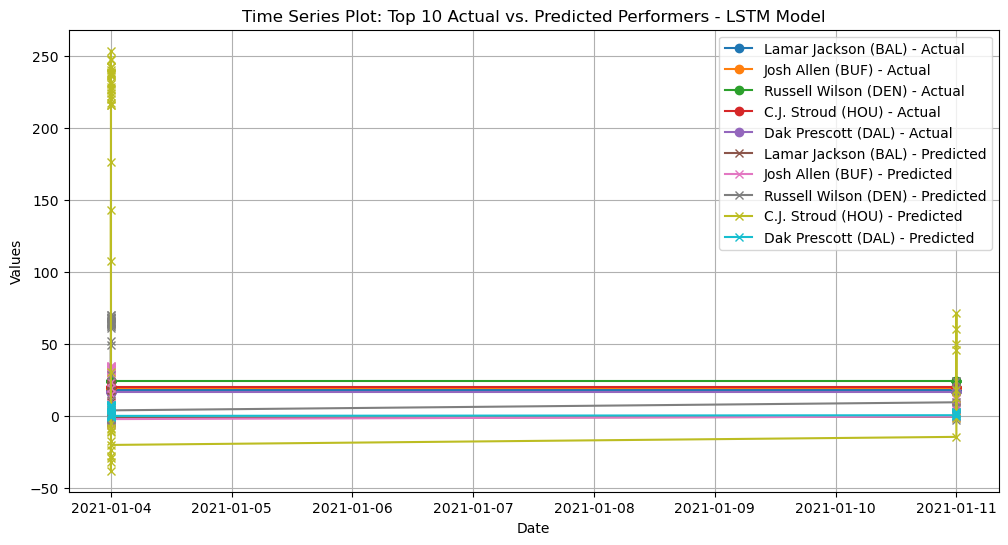

In [37]:
import matplotlib.pyplot as plt

dates = data['DATE']

import matplotlib.pyplot as plt

# Assuming you have predictions_rescaled, Y_test_rescaled, and dates as NumPy arrays
# These are the rescaled actual and predicted values after inverse scaling, and the original dates

# Identify 10 specific players
selected_players = ['Lamar Jackson (BAL)', 'Josh Allen (BUF)', 'Russell Wilson (DEN)', 'C.J. Stroud (HOU)', 'Dak Prescott (DAL)']

# Filter data for selected players
selected_players_data = data[data['PLAYER'].isin(selected_players)]

# Filter actual and predicted values for selected players
selected_actual_values = selected_players_data.pivot(index='DATE', columns='PLAYER', values='AVG_FPTS').values
selected_predicted_values = predictions_rescaled[:len(selected_actual_values)]

# Time Series Plot for Top 10 Actual vs. Predicted Performers
plt.figure(figsize=(12, 6))

# Plot the selected actual values
for i in range(len(selected_players)):
    plt.plot(dates[:len(selected_actual_values)], selected_actual_values[:, i], label=f'{selected_players[i]} - Actual', marker='o')

# Plot the corresponding predicted values
for i in range(len(selected_players)):
    plt.plot(dates[:len(selected_predicted_values)], selected_predicted_values[:, i], label=f'{selected_players[i]} - Predicted', marker='x')

plt.title('Time Series Plot: Top 10 Actual vs. Predicted Performers - LSTM Model')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

